# Fitting data with correlated uncertainties

We sometimes want to combine results from different studies. If these results have independent uncertainties and can be expected to have the same mean, then the optimal combination (minimum variance) is given by a weighted mean, where the weight is inversely proportional to the variance (uncertainty squared) of each individual input value. [This is a well-known result](https://en.wikipedia.org/wiki/Inverse-variance_weighting).

If the uncertainties of the results are correlated, it is more complicated to compute an optimally weighted mean. Instead of deriving analytical formulas, we use a fit here to obtain the mixing weight, which is equivalent. It serves to demonstrate how fits to correlated data values can be carried out. A whole project built on this approach is [GammaCombo](https://gammacombo.github.io/).

We consider a toy example where two measurements should be combined which have strongly correlated systematic uncertainties.

In [11]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

Here are the results we want to comine. The statistical uncertainties are assumed to be uncorrelated, the systematic uncertainties are assumed to be perfectly correlated (represented by thick bars in the plot).

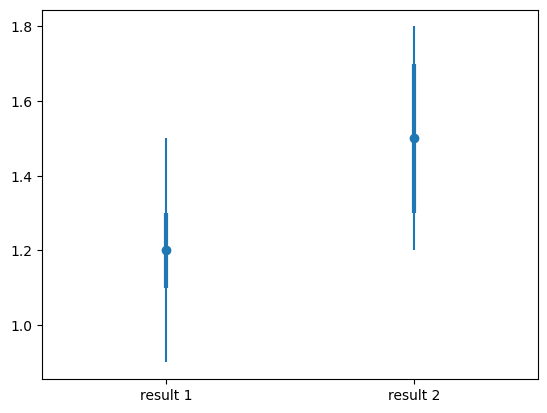

In [12]:
value = [1.2, 1.5]
error_sta = [0.3, 0.3]
error_sys = [0.1, 0.2]
correlation_sys = 1.0

plt.errorbar(("result 1", "result 2"), value, error_sta, fmt="o")
plt.errorbar(("result 1", "result 2"), value, error_sys, lw=3, fmt="none")
plt.xlim(-0.5, 1.5);

We formulate the combination as a fitting problem. We assume that both results originate from a common true value, which we can estimate in the usual way. Our objective function is derived from the log-probability of a multivariate normal distribution (in the derivation we dropped constants and scaled the result). We predict the constant mean of this distribution, which is matched to the two observed values while taking their covariance into account. The covariance matrix of the multivariate normal distribution captures the correlated uncertainties of the individual results.

The combined result obtained in this way is unbiased (assuming all inputs are unbiased) and also happens to minimize the variance, so this approach is optimal (unbiased and has minimum variance) even if the input results are not distributed like a multivariate normal.

The simpler special case for uncorrelated observations is handled in `iminuit.cost.LeastSquares`, but for the general case there is no ready-made cost function yet, so we write it here.

In [13]:
# construct covariance matrices
cov_sta = np.diag(np.square(error_sta))
cov_sys = np.diag(np.square(error_sys))
cov_sys[0, 1] = error_sys[0] * error_sys[1] * correlation_sys
cov_sys[1, 0] = cov_sys[0, 1]

# total covariance is sum of individual contributions
cov = cov_sta + cov_sys
inv_cov = np.linalg.inv(cov)

def model(x, z):
    """Return combined value based on input x and mixing parameter z."""
    return z * x[1] + (1 - z) * x[0]

def cost(z):
    """Chi-square distributed cost function."""
    xp = model(value, z)
    delta = value - xp
    return np.einsum("i,j,ij", delta, delta, inv_cov)

# with this extra information, iminuit will also print the chi2/ndof gof statistic
cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = len(value)

m = Minuit(cost, 0.5)
m.limits["z"] = (0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.4737 (χ²/ndof = 0.5)     │              Nfcn = 13               │
│ EDM = 1.46e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z    │    0.4    │    0.7    │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     z │
├───┼───────┤
│ z │ 0.737 │
└───┴───────┘

Our fit gives more weight to the more accurate measurement, as expected. In order to find the statistical and systematic uncertainty of the combined result, we do error propagation. We compute the trivial Jacobian for our model analytically.

total = 1.33 +/- 0.21(sta) + 0.16(sys)


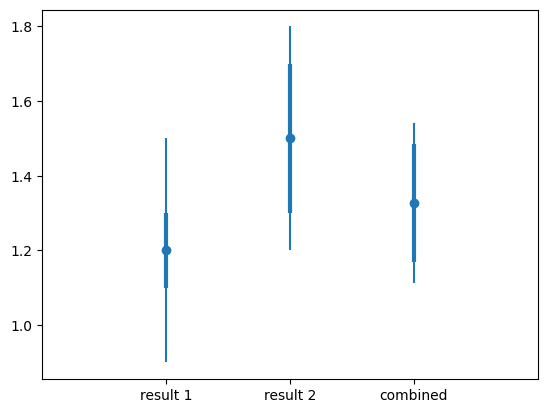

In [14]:
z = m.values[0]
jac = np.array([z, (1-z)])
total = model(value, z)
total_err_sta = np.einsum("i,j,ij", jac, jac, cov_sta) ** 0.5
total_err_sys = np.einsum("i,j,ij", jac, jac, cov_sys) ** 0.5

print(f"total = {total:.2f} +/- {total_err_sta:.2f}(sta) + {total_err_sys:.2f}(sys)")

plt.errorbar(("result 1", "result 2", "combined"), value + [total], error_sta + [total_err_sta], fmt="o")
plt.errorbar(("result 1", "result 2", "combined"), value + [total], error_sys + [total_err_sys], lw=3, fmt="none")
plt.xlim(-1, 3);

Note how the systematic uncertainty gets barely reduced by the combination, a consequence of the strong correlation. Try running this example with zero correlation to see how the uncertainty becomes smaller.

## Further reading

[Schmelling (2000)](https://arxiv.org/abs/hep-ex/0006004) argues that a combination may ignore data correlations if they are not well-known, because a result of a combination that ignores correlations is still unbiased, it merely does not have minimum possible variance. Depending on the situation, this may be preferable over the result shown here which takes the correlation into account, since one then has to propagate the uncertainty of correlation into the combined result.

[Cowan (2018)](https://inspirehep.net/literature/1694207) demonstrates that it is techniqually feasible and beneficial to include uncertainties on uncertainties explicitly in the likelihood when combining measurements.

[Barlow (2022)](https://inspirehep.net/literature/1509024) discusses two commonly used techniques to combine measurements with correlated systematic uncertainties, and shows under which conditions they are equivalent.